# Demo potentiel solaire -- Halifax

In [102]:
import numpy as np
import pandas as pd
import pyarrow as pa
import ast
import operator
from typing import Callable, Iterator

import pyarrow.parquet as pq
import pyarrow.compute as pc
import overturemaps
from palettable.colorbrewer.sequential import Reds_6
from palettable.colorbrewer.diverging import Spectral_5
from pathlib import Path
import polars as pl
from deltalake import DeltaTable, write_deltalake
import ast

In [6]:
import lonboard
from lonboard import Map, PolygonLayer, SolidPolygonLayer, viz
from lonboard.colormap import apply_continuous_cmap
import geoarrow.rust.core
from geoarrow.rust.io import read_parquet
import bokeh, ipyleaflet
import geopandas as gpd
import leafmap
from matplotlib.colors import LogNorm
# import leafmap.deckgl as leafmap

In [3]:
from deltalake import write_deltalake

In [4]:
lonboard.__version__

'0.10.3'

In [9]:
pl.__version__

'1.17.1'

In [84]:
from palettable.matplotlib import Magma_11
from palettable.matplotlib import Viridis_11

# Define parameters for our custom color scheme
center = 180
min_value = 90
max_value = 270
num_colors = 11

# Create a custom color palette using palettable
custom_colors = Magma_11.mpl_colors + Viridis_11.mpl_colors[::-1]
custom_colors

[(0.0, 0.0, 0.01568627450980392),
 (0.08235294117647059, 0.054901960784313725, 0.2196078431372549),
 (0.23137254901960785, 0.058823529411764705, 0.4392156862745098),
 (0.39215686274509803, 0.10196078431372549, 0.5019607843137255),
 (0.5490196078431373, 0.1607843137254902, 0.5058823529411764),
 (0.7176470588235294, 0.21568627450980393, 0.4745098039215686),
 (0.8705882352941177, 0.28627450980392155, 0.40784313725490196),
 (0.9647058823529412, 0.43137254901960786, 0.3607843137254902),
 (0.996078431372549, 0.6235294117647059, 0.42745098039215684),
 (0.996078431372549, 0.8117647058823529, 0.5725490196078431),
 (0.9882352941176471, 0.9921568627450981, 0.7490196078431373),
 (0.9921568627450981, 0.9058823529411765, 0.1450980392156863),
 (0.7411764705882353, 0.8745098039215686, 0.14901960784313725),
 (0.47843137254901963, 0.8196078431372549, 0.3176470588235294),
 (0.25882352941176473, 0.7450980392156863, 0.44313725490196076),
 (0.13333333333333333, 0.6588235294117647, 0.5176470588235295),
 (0.1

In [71]:
# Colors at https://natural-resources.canada.ca/energy/energy-sources-distribution/renewables/solar-photovoltaic-energy/tools-solar-photovoltaic-energy/photovoltaic-and-solar-resource-maps/18366
# Annual PV potential; south facing with latitude tilt
gc_pv_colors = {
    '0-500': '#010080',
    '500-600': '#0000CC',
    '600-700': '#0099FF',
    '700-800': '#009999',
    '800-900': '#01CC00',
    '900-1000': '#00FF01',
    '1000-1100': '#CCFF00',
    '1100-1200': '#FFFF00',
    '1200-1300': '#FFCC00',
    '1300-1400': '#FE9900',
    '1400+': '#FE332D'
}

In [82]:
# Function to convert hexadecimal to RGBA
def hex_to_rgba(hex_color):
    hex_color = hex_color.lstrip('#')
    if len(hex_color) == 3:
        hex_color = ''.join([c*2 for c in hex_color])
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)] + [255]

# Get the list of colors and convert them to RGBA
color_list = [hex_to_rgba(color) for color in gc_pv_colors.values()]

# Convert the list to a numpy array and ensure uint8 type
color_array = np.array(color_list, dtype=np.uint8)

In [75]:
def hex_to_rgba(hex_color):
    hex_color = hex_color.lstrip('#')
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)] + [255]

In [77]:
color_list = [hex_to_rgba(color) for color in gc_pv_colors.values()]

print(color_list)

[[1, 0, 128, 255], [0, 0, 204, 255], [0, 153, 255, 255], [0, 153, 153, 255], [1, 204, 0, 255], [0, 255, 1, 255], [204, 255, 0, 255], [255, 255, 0, 255], [255, 204, 0, 255], [254, 153, 0, 255], [254, 51, 45, 255]]


In [79]:
color_list = np.array([[1, 8, 128, 255], [0, 0, 204, 255], [0, 153, 255, 255], [0, 153, 153, 255],
                       [1, 204, 0, 255], [0, 255, 1, 255], [204, 255, 0, 255], [255, 255, 0, 255],
                       [255, 204, 0, 255], [254, 153, 0, 255], [254, 51, 45, 255]])

In [91]:
from palettable.cubehelix import Cubehelix
palette = Cubehelix.make(start_hue=1, end_hue=1, n=16)

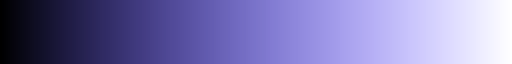

In [92]:
palette.mpl_colormap

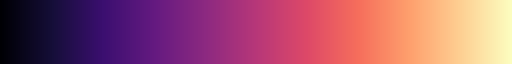

In [98]:
Magma_11.mpl_colormap

In [ ]:
Blues_8.mpl_colors

In [ ]:
custom_colors

In [ ]:
geoarrow.rust.core.__version__

In [ ]:
lonboard.__version__

## Open gpkg with roof data

In [10]:
halifax_hood = Path("Halifax_aoi_2D_5.gpkg") # Autobuilding lidar

In [109]:
halifax_hood_3D = Path("Halifax_0_0_1_aoi_3D.gpkg") # Autobuilding lidar

In [12]:
halifax_hood_LOD = Path("Halifax_0_0_1_aoi_CityJSON_LOD_2.2_Demo.gpkg") # Autobuilding lidar

In [110]:
# gdf = gpd.read_file(halifax_hood)

#gdf = gpd.read_file(halifax_hood)
gdf_3D = gpd.read_file(halifax_hood_3D)
gdf_LOD = gpd.read_file(halifax_hood_LOD)


#gdf = gpd.read_file(halifax_hood, convert_categoricals=False)

In [112]:
gdf_3D

,SHAPE_Area,SHAPE_Leng,acqtech,acqtech_en,acqtech_fr,bldgarea,comment,datemax,datemin,elevmax,elevmin,feature_id,h_ground,haccmax,haccmin,heightmax,heightmin,md_id,provider,provideren,providerfr,qltylvl,qltylvl_en,qltylvl_fr,roof_type,vaccmax,vaccmin,geoflow_ID,building_part_ID,autobuilding_ID,lod,surface_count,ground_surface_count,wall_surface_count,roof_surface_count,roof_surface_sloped_count,roof_surface_flat_count,footprint_perimeter,ground_Z,roof_min_Z,roof_max_Z,roof_height_range,total_surface_area,total_ground_area,total_wall_area,total_roof_area,roof_sloped_area,roof_flat_area,actual_volume,surface_areas,surface_azimuths,surface_inclinations,wall_surface_areas,wall_surface_azimuths,wall_surface_inclinations,roof_surface_areas,roof_surface_azimuths,roof_surface_inclinations,roof_surface_types,southern_azimuth,southern_area,southern_rooftype,geometry
0,0.0,0.0,1360,Lidar,Lidar,83.24,None,20180530,20180509,51.26,50.77,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,50.79,2.0,2.0,8.57,2.03,None,461,Municipal,Municipal,23,Excellent,Excellent,slanted,1.0,1.0,1,1-0,10,2.2,44,1,39,4,4,0,41.29,50.79,52.97,60.03,7.06,478.92,83.23,287.74,99.59,99.59,0.00,618.30,"[85.93, 6.13, 27.13, 0.69, 7.6, 0.43, 0.72, 13...","[0.0, 35.27, 32.74, 32.74, 218.13, 125.27, 218...","[180.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90...","[6.13, 27.13, 0.69, 7.6, 0.43, 0.72, 13.12, 11...","[35.27, 32.74, 32.74, 218.13, 125.27, 218.13, ...","[90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90....","[57.54, 0.07, 8.06, 39.58]","[307.69, 38.48, 219.04, 127.69]","[33.82, 29.8, 28.43, 33.82]","['sloped', 'sloped', 'sloped', 'sloped']",219.04,8.06,sloped,MULTIPOLYGON Z (((451615.812 4940179.385 50.79...
1,0.0,0.0,1360,Lidar,Lidar,170.73,None,20180530,20180509,51.02,49.61,e758c42a-5725-4cc9-9ee9-60432c998262,49.66,2.0,2.0,10.08,1.59,None,461,Municipal,Municipal,23,Excellent,Excellent,slanted,1.0,1.0,10,10-0,198,2.2,46,1,37,8,6,2,59.26,49.66,52.78,60.59,7.81,856.61,170.77,474.07,190.03,177.47,12.56,1563.10,"[192.14, 8.71, 2.9, 9.57, 8.37, 15.31, 0.09, 4...","[0.0, 333.95, 62.67, 64.46, 153.95, 62.67, 62....","[180.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90...","[8.71, 2.9, 9.57, 8.37, 15.31, 0.09, 4.81, 0.8...","[333.95, 62.67, 64.46, 153.95, 62.67, 62.67, 1...","[90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90....","[27.49, 8.04, 4.53, 8.03, 24.63, 8.49, 65.35, ...","[333.43, 90.0, 90.0, 152.97, 152.49, 331.05, 6...","[32.57, 0.57, 0.57, 33.53, 32.79, 32.29, 22.69...","['sloped', 'flat', 'flat', 'sloped', 'sloped',...",152.97,8.03,sloped,MULTIPOLYGON Z (((451937.176 4939701.398 49.66...
2,0.0,0.0,1360,Lidar,Lidar,160.10,None,20180530,20180509,49.82,48.73,b9293b46-ff0c-4297-beaf-84a3bfff8641,48.76,2.0,2.0,7.19,2.01,None,461,Municipal,Municipal,23,Excellent,Excellent,slanted,1.0,1.0,100,100-0,2127,2.2,77,1,69,7,6,1,56.25,48.76,51.98,56.60,4.62,706.10,157.31,341.46,168.08,147.78,20.30,1012.58,"[174.48, 8.23, 5.85, 3.6, 0.25, 1.64, 1.41, 3....","[0.0, 309.73, 277.48, 127.67, 219.29, 186.34, ...","[180.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90...","[8.23, 5.85, 3.6, 0.25, 1.64, 1.41, 3.85, 4.2,...","[309.73, 277.48, 127.67, 219.29, 186.34, 71.93...","[90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90....","[3.42, 27.21, 9.26, 66.45, 63.38, 11.17, 9.28]","[38.93, 180.0, 306.66, 218.66, 38.66, 308.33, ...","[19.57, 0.0, 32.24, 18.62, 18.62, 33.13, 31.85]","['sloped', 'flat', 'sloped', 'sloped', 'sloped...",180.00,27.21,flat,"MULTIPOLYGON Z (((451773.27 4939996.155 48.76,..."
3,0.0,0.0,1360,Lidar,Lidar,119.93,Detection of Lidar points classified as ground...,20180530,20180509,46.43,44.41,ab5aa68b-d4c8-4f6a-ae65-8e34c32a0347,44.59,2.0,2.0,6.20,2.01,None,461,Municipal,Municipal,23,Excellent,Excellent,slanted,1.0,1.0,101,101-0,2141,2.2,33,1,29,3,2,1,45.37,44.59,48.46,52.52,4.07,482.99,98.17,270.36,106.22,76.95,29.27,604.33,"[102.34, 4.96, 64.06, 1.76, 7.53, 1.75, 0.93, ...","[0.0, 119.89, 211.46, 211.46, 211.46, 301.94, ...","[180.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90...","[4.96, 64.06, 1.76,

## Manually adjust heights to the geoid @ Halifax

In [14]:
# calc for Halifax : 20.447m
# https://webapp.csrs-scrs.nrcan-rncan.gc.ca/geod/tools-outils/gpsh.php

# altitude according to PVGIS : 56 m

offset_approx = 22.35  
offset_website = 20.447  # The amount to subtract from all altitudes
offset_PVGIS = 56  # The amount to subtract from all altitudes

offset = offset_PVGIS # The amount to subtract from all altitudes

# Apply the translation to all geometries
gdf_LOD['geometry'] = gdf_LOD['geometry'].translate(xoff=0, yoff=0, zoff=-offset)

In [26]:
gdf = gdf_LOD

In [16]:
pd.set_option('display.max_columns', None)
#print(gdf.dtypes)

In [ ]:
gdf.head(50)

In [30]:
# specify the columns you want to keep
columns_to_keep = ['feature_id', 'bldgarea', 
                    'roof_surface_areas', 'roof_surface_azimuths', 
                    'roof_surface_inclinations', 'roof_surface_types', 'southern_azimuth', 'southern_area', 'southern_rooftype','geometry']
list1 = columns_to_keep

columns_to_keep = ['attribute.feature_id', 'attribute.bldgarea', 
                   'attribute.southern_azimuth', 'attribute.southern_area', 'attribute.southern_rooftype', 'attribute.heightmax', 'geometry']

list2 = columns_to_keep

In [ ]:
dict1 = {item: item for item in list1}

In [ ]:
dict1

In [ ]:
dict2 = {}
for key in list1:
    if f'attribute.{key}' in list2:
        dict2[key] = f'attribute.{key}'
    elif key in list2:  # For 'geometry' which doesn't have 'attribute.' prefix
        dict2[key] = key
    else:
        dict2[key] = None

In [ ]:
dict2

In [31]:
# drop columns that are not specified in the list
gdf = gdf.drop(gdf.columns.drop(columns_to_keep), axis=1, errors='ignore')

In [58]:
gdf.head()

,attribute.bldgarea,attribute.feature_id,attribute.heightmax,attribute.southern_azimuth,attribute.southern_area,attribute.southern_rooftype,geometry,attribute.southern_azimuth_transformed,solar_potential_index,number_panels
0,83.24,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,8.57,219.04,8.06,sloped,MULTIPOLYGON Z (((451615.812 4940179.385 -5.21...,141,3,4
1,83.24,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,8.57,219.04,8.06,sloped,"MULTIPOLYGON Z (((451617.178 4940177.072 1.36,...",141,3,4
2,83.24,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,8.57,219.04,8.06,sloped,MULTIPOLYGON Z (((451616.472 4940180.855 3.766...,141,3,4
3,83.24,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,8.57,219.04,8.06,sloped,MULTIPOLYGON Z (((451616.737 4940180.686 -3.02...,141,3,4
4,83.24,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,8.57,219.04,8.06,sloped,MULTIPOLYGON Z (((451607.514 4940169.24 -1.377...,141,3,4


In [51]:
def transform_series_old(series):
    """
    Transform values in a pandas Series from range [0, 360] to [0, 180].
    With a maximum at 180, so 
    170 => 170
    190 => 170
    
    Args:
        series (pandas Series): A pandas Series of floating-point values
    
    Returns:
        pandas Series: Transformed Series
    """
    return series.where(series <= 180, 360 - series)

def transform_series(series):
    """
    Transform values in a pandas Series from range [0, 360] to [0, 180].
    With a maximum at 180, so 
    170 => 170
    190 => 170
    
    Args:
        series (pandas Series): A pandas Series of floating-point values
    
    Returns:
        pandas Series: Transformed Series
    """
    # Convert series to float if it's not already
    series = pd.to_numeric(series, errors='coerce')
    # Round to nearest integer
    series = series.round().astype(int)
    
    # Apply the transformation
    return series.where(series <= 180, 360 - series)


In [55]:
# Function to calculate solar index

def calculate_solar_potential_old(df, minimum_area=1.65):
    """
    Calculate the solar potential index and the number of panels for a given roof surface.

    Parameters:
    df (pandas DataFrame): The DataFrame containing the roof surface data.
    minimum_area (float, optional): The minimum area required for a roof surface to be considered for solar panels. Default is 1.65 square meters.

    Returns:
    None

    """
      # Transform to azimuth max = 180 
    df['attribute.southern_azimuth_transformed'] = df['attribute.southern_azimuth'].apply(lambda x: transform_series(pd.Series([x]))[0])
    # Calculate the solar potential index

    df['solar_potential_index'] = np.where(
                                      (df['attribute.southern_rooftype'] == 'flat'), 5,
                                  np.where(
                                      (df['attribute.southern_area'] < minimum_area) | (df['attribute.southern_azimuth_transformed'] <= 90), 0,
                                        np.round((df['attribute.southern_azimuth_transformed'] - 90) / 18).clip(0, 5)
                                    )
                                  ).astype(int)

    df['number_panels'] = np.floor(df['attribute.southern_area'] / minimum_area).astype(int)

def calculate_solar_potential(df, minimum_area=1.65):
    """
    Calculate the solar potential index and the number of panels for a given roof surface.

    Parameters:
    df (pandas DataFrame): The DataFrame containing the roof surface data.
    minimum_area (float, optional): The minimum area required for a roof surface to be considered for solar panels. Default is 1.65 square meters.

    Returns:
    None
    """
    # Convert area to float
    df['attribute.southern_area'] = pd.to_numeric(df['attribute.southern_area'], errors='coerce')

    # Transform to azimuth max = 180 and convert to float
    df['attribute.southern_azimuth_transformed'] = transform_series(df['attribute.southern_azimuth'])

    # Calculate the solar potential index
    df['solar_potential_index'] = np.where(
        (df['attribute.southern_rooftype'] == 'flat'), 5,
        np.where(
            (df['attribute.southern_area'] < minimum_area) | (df['attribute.southern_azimuth_transformed'] <= 90), 0,
            np.round((df['attribute.southern_azimuth_transformed'] - 90) / 18).clip(0, 5)
        )
    ).astype(int)

    df['number_panels'] = np.floor(df['attribute.southern_area'] / minimum_area).astype(int)

In [56]:
def calculate_solar_azimuth_index(df, index_max=10):
    """
    Calculate the solar azimuth index based on the southern azimuth.
    
    Parameters:
    df (pandas DataFrame): The DataFrame containing the 'attribute.southern_azimuth' column.
    index_max (int): The maximum value for the solar azimuth index. Default is 10.
    
    Returns:
    None (modifies the DataFrame in place)
    """
    
    # Define the step size
    step = 90 / index_max
    
    # Create the conditions and values for the index
    conditions = [
        (df['attribute.southern_azimuth'] < 90) | (df['attribute.southern_azimuth'] > 270),
        (df['attribute.southern_azimuth'] >= 180 - step/2) & (df['attribute.southern_azimuth'] <= 180 + step/2)
    ]
    values = [0, index_max]
    
    # Add conditions and values for decreasing index on both sides of 180
    for i in range(1, index_max):
        lower_bound = 180 - (i+0.5)*step
        upper_bound = 180 + (i+0.5)*step
        conditions.append((df['attribute.southern_azimuth'] >= lower_bound) & (df['attribute.southern_azimuth'] < 180 - (i-0.5)*step))
        conditions.append((df['attribute.southern_azimuth'] > 180 + (i-0.5)*step) & (df['attribute.southern_azimuth'] <= upper_bound))
        values.extend([index_max - i, index_max - i])
    
    # Apply the conditions to create the solar_azimuth_index
    df['solar_azimuth_index'] = np.select(conditions, values, default=0)

# Usage
# calculate_solar_azimuth_index(df, index_max=10)


In [57]:
calculate_solar_potential(gdf) # modifies gdf
#calculate_solar_azimuth_index(gdf, index_max=10)

## Arrow table stuff

In [ ]:
gdf_arrow = gdf.to_arrow()

In [ ]:
type(gdf_arrow)

In [ ]:
gdf_arrow # The returned data object needs to be consumed by a library implementing the Arrow PyCapsule Protocol. For example, wrapping the data as a pyarrow.Table

In [ ]:
table = pa.table(gdf_arrow)

In [ ]:
table.column_names

In [ ]:
def apply_operation(table, col1, col2, op):
    # Convert ChunkedArrays to Python lists
    list1 = table.column(col1).to_pylist()
    list2 = table.column(col2).to_pylist()
    
    # Convert string representations to actual lists of floats
    list1 = [ast.literal_eval(x) for x in list1]
    list2 = [ast.literal_eval(x) for x in list2]
    
    # Apply the operation element-wise
    result = []
    for a, b in zip(list1, list2):
        result.append([op(x, y) for x, y in zip(a, b)])
    
    # Convert the result back to a ChunkedArray
    result_strings = [str(x) for x in result]
    return pa.chunked_array([pa.array(result_strings)])

In [ ]:
def string_to_float_list(s: str) -> list:
    return [float(x) for x in ast.literal_eval(s)]

def apply_operation_gen(col1: pa.ChunkedArray, col2: pa.ChunkedArray, op: Callable) -> Iterator[str]:
    for item1, item2 in zip(col1, col2):
        list1 = string_to_float_list(item1.as_py())
        list2 = string_to_float_list(item2.as_py())
        result = [op(x, y) for x, y in zip(list1, list2)]
        yield str(result)

def apply_operation_v2(table: pa.Table, col1_name: str, col2_name: str, op: Callable) -> pa.ChunkedArray:
    col1 = table.column(col1_name)
    col2 = table.column(col2_name)
    result_list = list(apply_operation_gen(col1, col2, op))
    return pa.chunked_array([pa.array(result_list)])

In [ ]:
%%time
result = apply_operation(table, 'roof_surface_azimuths', 'roof_surface_areas', operator.sub)

In [ ]:
%%time
result_gen = apply_operation_v2(table, 'roof_surface_azimuths', 'roof_surface_areas', operator.sub)

In [ ]:
result

In [ ]:
table.column('roof_surface_azimuths')[0]

## GDF stuff

In [61]:
gdf

,attribute.bldgarea,attribute.feature_id,attribute.heightmax,attribute.southern_azimuth,attribute.southern_area,attribute.southern_rooftype,geometry,attribute.southern_azimuth_transformed,solar_potential_index,number_panels
0,83.24,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,8.57,219.04,8.06,sloped,MULTIPOLYGON Z (((451615.812 4940179.385 -5.21...,141,3,4
1,83.24,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,8.57,219.04,8.06,sloped,"MULTIPOLYGON Z (((451617.178 4940177.072 1.36,...",141,3,4
2,83.24,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,8.57,219.04,8.06,sloped,MULTIPOLYGON Z (((451616.472 4940180.855 3.766...,141,3,4
3,83.24,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,8.57,219.04,8.06,sloped,MULTIPOLYGON Z (((451616.737 4940180.686 -3.02...,141,3,4
4,83.24,1ddd9cff-f4af-4254-b4cd-415fd1507fcd,8.57,219.04,8.06,sloped,MULTIPOLYGON Z (((451607.514 4940169.24 -1.377...,141,3,4
...,...,...,...,...,...,...,...,...,...,...
15809,95.9,af2342c1-6b7f-4e06-aeeb-97f1353bbd6c,6.21,180,20.49,flat,MULTIPOLYGON Z (((451637.207 4940027.548 -1.02...,180,5,12
15810,95.9,af2342c1-6b7f-4e06-aeeb-97f1353bbd6c,6.21,180,20.49,flat,MULTIPOLYGON Z (((451631.96 4940022.268 -5.274...,180,5,12
15811,95.9,af2342c1-6b7f-4e06-aeeb-97f1353bbd6c,6.21,180,20.49,flat,MULTIPOLYGON Z (((451638.405 4940030.285 -2.74...,180,5,12
15812,95.9,af2342c1-6b7f-4e06-aeeb-97f1353bbd6c,6.21,180,20.49,flat,MULTIPOLYGON Z (((451636.792 4940026.709 -1.50...,180,5,12


In [59]:
az_index = gdf['attribute.southern_azimuth'].to_numpy()
az_normalized = gdf['attribute.southern_azimuth_transformed'].to_numpy() 

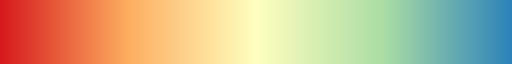

In [103]:
Spectral_5.mpl_colormap
#type(Reds_6)
# RdBu_9.mpl_colormap

In [ ]:
colors = apply_continuous_cmap(normalized_heights, Spectral_5)

In [ ]:
heights = gdf['attribute.heightmax'].to_numpy()
heights = np.nan_to_num(heights, nan=1)

In [ ]:
normalizer = LogNorm(1, heights.max(), clip=True)
normalized_heights = normalizer(heights)
# normalizer = LogNorm(1, roof_directions.max(), clip=True)
# normalized_heights = normalizer(roof_directions)

In [ ]:
# colors = apply_continuous_cmap(az_normalized / 180, RdBu_9) # Reds_6)
colors = apply_continuous_cmap(az_index / 10, Reds_6) # Reds_6)

In [ ]:
print(gdf['solar_azimuth_index'].value_counts())

In [ ]:
layer25 = PolygonLayer.from_geopandas(
    gdf,
#    wireframe=True,
#    extruded=True,
#    filled=True,
#    get_fill_color=colors,
#    get_elevation=heights,
#    auto_highlight=True,
 #   pickable=True,
    #get_fill_color=np.flip(colors),
)

In [ ]:
layer3D = PolygonLayer.from_geopandas(
    gdf_3D,
#    wireframe=True,
#    extruded=True,
#    filled=True,
#    get_fill_color=colors,
#    get_elevation=heights,
#    auto_highlight=True,
 #   pickable=True,
    #get_fill_color=np.flip(colors),
)

In [89]:
flipped_colors = np.flip(custom_colors)

In [106]:
#layerLOD =SolidPolygonLayer.from_geopandas(
layerLOD =PolygonLayer.from_geopandas(
    gdf_LOD,
    line_joint_rounded=True,
#    elevation_scale = 0,
#   wireframe=True,
#    extruded=True,
#    filled=True,
#get_fill_color=Spectral_5,
#    get_elevation=heights,
#    auto_highlight=True,
#   pickable=False,
    #get_fill_color=np.flip(colors),
)

In [ ]:
view_state_halifax = {
    "longitude": -63.55, # Longitude at the map center
    "latitude": 44.62, # Latitude at the map center
    "zoom": 12.726630492730596,
    "pitch": 0, # Pitch angle in degrees. `0` is top-down.
    "bearing": 0, # Bearing angle in degrees. `0` is north.
}

In [ ]:
layer = PolygonLayer(
    # Select only a few attribute columns from the table
    # AttributeError: 'geoarrow.rust.core._rust.GeoTable' object [table_parquet_geoarrow_rust] has no attribute 'select'
    table=table_pq.select(["feature_id", "md_id", 
                           "acqtech", "acqtech_en", "acqtech_fr",
                           "elevmin", "elevmax", "bldgarea", "comment", "geometry"]),
    #extruded=True,
    wireframe=False,
    extruded=False,
    filled=False,
    # stroked=False,
    #get_elevation=heights,
    #get_fill_color=colors,
)

In [107]:
m = Map(layerLOD,  _height=800)
#m = Map(layer, view_state=view_state_halifax, _height=800)

In [115]:
m

Map(custom_attribution='', layers=(PolygonLayer(line_joint_rounded=True, selected_index=11925, table=arro3.cor…

# Photovoltaic potential of buildings
As a function of azimuth angles of rooftop surfaces

In [ ]:
m

Let's color the buildings by their **roof_direction**". First, convert the "roof_direction" column to a numpy array, then replace any null values with 1.

In [ ]:
# Buggy : TraitError: accessor must have same length as table
roof_directions = table["roof_direction"].to_numpy()
roof_directions = np.nan_to_num(roof_directions, nan=1)

Then we can apply a colormap to these heights. For this case, we'll use the Oranges_9 colormap.

In [ ]:
new_color = Reds_6.hex_colors

Using apply_continuous_cmap, we can apply our values onto this colormap.

In [ ]:
colors = apply_continuous_cmap(normalized_heights, Oranges_9)

In [ ]:
colors

In [4]:
# Colors at https://natural-resources.canada.ca/energy/energy-sources-distribution/renewables/solar-photovoltaic-energy/tools-solar-photovoltaic-energy/photovoltaic-and-solar-resource-maps/18366
# Annual PV potential; south facing with latitude tilt
gc_pv_colors = {
    '0-500': '#010080',
    '500-600': '#0000CC',
    '600-700': '#0099FF',
    '700-800': '#009999',
    '800-900': '#01CC00',
    '900-1000': '#00FF01',
    '1000-1100': '#CCFF00',
    '1100-1200': '#FFFF00',
    '1200-1300': '#FFCC00',
    '1300-1400': '#FE9900',
    '1400+': '#FE332D'
}
len(gc_pv_colors)

11

In [3]:
import IPython.display as ipd

for interval, color in gc_pv_colors.items():
    ipd.display(ipd.HTML(f"<span style='background-color:{color}; color:white; padding:5px'>{interval}</span>"))

We create a PolygonLayer with our data, passing in the heights and colors from before.

In [ ]:
layer = PolygonLayer(
    # Select only a few attribute columns from the table
    table=table.select(["attribute.feature_id","geometry",]),
    extruded=False,
    wireframe=False,
    # extruded=False,
    # filled=False,
    # stroked=False,
    #get_elevation=heights,
    #get_fill_color=colors,
)

We manually set the view state here for the original NYC data so that the map will start pitched. Remove or change this view_state call if you change the input dataset.

In [ ]:
view_state_halifax = {
    "longitude": -63.56, # Longitude at the map center
    "latitude": 44.625, # Latitude at the map center
    "zoom": 12.726630492730596,
    "pitch": 59.80465353190481, # Pitch angle in degrees. `0` is top-down.
    "bearing": 13.243243243243244, # Bearing angle in degrees. `0` is north.
}

In [ ]:
view_state_nyc = {
    "longitude": -73.98416810282863, # Longitude at the map center
    "latitude": 40.72651721370669, # Latitude at the map center
    "zoom": 12.726630492730596,
    "pitch": 59.80465353190481, # Pitch angle in degrees. `0` is top-down.
    "bearing": 13.243243243243244, # Bearing angle in degrees. `0` is north.
}

In [ ]:
view_state_tokyo = {
    "longitude": 139.79, # Longitude at the map center
    "latitude": 35.73, # Latitude at the map center
    "zoom": 12.726630492730596,
    "pitch": 600, # Pitch angle in degrees. `0` is top-down.
    "bearing": 0, # Bearing angle in degrees. `0` is north.
}

In [ ]:
view_state_nb = {
    "longitude": -66.646332, # Longitude at the map center, Fredericton
    "latitude": 45.964993, # Latitude at the map center
    "zoom": 12.726630492730596,
    "pitch": 600, # Pitch angle in degrees. `0` is top-down.
    "bearing": 0, # Bearing angle in degrees. `0` is north.
}

In [ ]:
view_state_cgy = { 
    "longitude": -114, # Longitude at the map center, Fredericton
    "latitude": 51, # Latitude at the map center
    "zoom": 12.726630492730596,
    "pitch": 600, # Pitch angle in degrees. `0` is top-down.
    "bearing": 0, # Bearing angle in degrees. `0` is north.
}

In [ ]:
# view_state = view_state_nyc
view_state = view_state_halifax
# view_state = view_state_tokyo
# view_state = view_state_cgy
#view_state = view_state_nb

In [ ]:
m = Map(layer, view_state=view_state, _height=800)

In [ ]:
m